Qualitative investigation into if the DSprites augmentation sampling is working correctly. Might turn into proper tests later.

Also, can be used for reference as to how to specify the DSprites augmentation distribution.

In [1]:
%load_ext autoreload
%autoreload 2

import os
# Limit memory available to JAX
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.3"
from ml_collections import ConfigDict
from jax import random
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

In [2]:
from src.utils.datasets.augmented_dsprites import construct_augmented_dsprites, DistributionConfig, DistributionType

### Config for the dataset

In [3]:
import numpy as np
import math

dsprites_config = ConfigDict()

dsprites_config.square_distribution = ConfigDict()
dsprites_config.square_distribution.orientation = (
    f"uniform(low=0.0, high={math.pi * 2})"
)
dsprites_config.square_distribution.scale = (
    "truncated_normal(minval=0.55, maxval=1.0, loc=0.75, scale=0.2)"
)
dsprites_config.square_distribution.x_position = "uniform(low=0.5, high=0.95)"
dsprites_config.square_distribution.y_position = "uniform(low=0.5, high=0.95)"

dsprites_config.ellipse_distribution = ConfigDict()
dsprites_config.ellipse_distribution.orientation = (
    f"uniform(low=0.0, high={math.pi / 2})"
)
dsprites_config.ellipse_distribution.scale = (
    "truncated_normal(minval=0.5, maxval=0.85, loc=0.65, scale=0.15)"
)
dsprites_config.ellipse_distribution.x_position = (
    "truncated_normal(minval=0.1, maxval=0.9, loc=0.5, scale=0.25)"
)
dsprites_config.ellipse_distribution.y_position = (
    "truncated_normal(minval=0.35, maxval=0.65, loc=0.5, scale=0.15)"
)

dsprites_config.heart_distribution = ConfigDict()
dsprites_config.heart_distribution.orientation = f"delta(value=0.0)"
dsprites_config.heart_distribution.scale = "uniform(low=0.9, high=1.0)"
dsprites_config.heart_distribution.x_position = "uniform(low=0.1, high=0.5)"
dsprites_config.heart_distribution.y_position = (
    "biuniform(low1=0.1, high1=0.3, low2=0.7, high2=0.9)"
)

dsprites_config.heart_distribution.unnormalised_shape_prob = 1 / 3
dsprites_config.square_distribution.unnormalised_shape_prob = 1 / 3
dsprites_config.ellipse_distribution.unnormalised_shape_prob = 1 / 3

# Construct the dataset

In [4]:
# Get the dataset generator:
ds = construct_augmented_dsprites(dsprites_config, random.PRNGKey(11))

I0000 00:00:1706801629.046503 1346606 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


# Latent distribution matches expected check

Check that the empirical distribution of the latents returned by the dataset matches that expected from the config:

In [5]:
from src.utils.datasets.augmented_dsprites import DspritesLatent


def extract_latents_from_example(example: dict):
    return DspritesLatent(
        value_orientation=float(example["value_orientation"]),
        value_scale=float(example["value_scale"]),
        value_x_position=float(example["value_x_position"]),
        value_y_position=float(example["value_y_position"]),
        label_shape=int(example["label_shape"]),
    )

In [6]:
num_samples = 30000
latents = [extract_latents_from_example(example) for example in ds.take(num_samples)]
latents_by_shape = {
    "square": [l for l in latents if l.label_shape == 0],
    "ellipse": [l for l in latents if l.label_shape == 1],
    "heart": [l for l in latents if l.label_shape == 2],
}
print("Roughly an equal proportion of examples:", {shape: len(latents) for shape, latents in latents_by_shape.items()})

Roughly an equal proportion of examples: {'square': 10006, 'ellipse': 9948, 'heart': 10046}


In [8]:
import matplotlib
text_width = 6.75  # in  --> Confirmed with template explanation
line_width = 3.25 # in
dpi = 300

fs_m1 = 6  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9  #  figure titles

matplotlib.rc("font", size=fs)  # controls default text sizes
matplotlib.rc("axes", titlesize=fs)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=fs)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=fs_m1)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=fs_m1)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=7)  # legend fontsize
# matplotlib.rc(
#     "figure", titlesize=fs_p1, dpi=dpi, autolayout=True
# )  # fontsize of the figure
matplotlib.rc("lines", linewidth=1, markersize=3)
# matplotlib.rc("savefig", dpi=1200, bbox="tight")
matplotlib.rc("grid", alpha=0.3)
matplotlib.rc("axes", grid=True)

matplotlib.rc("font", **{"family": "serif", "serif": ["Times New Roman"]})
matplotlib.rc("text", usetex=True)
# add amsmath to the latex preamble
matplotlib.rcParams['text.latex.preamble'] = ''.join([
        r"\usepackage{amsmath}",   
        r"\usepackage{amsfonts}",           
        r"\usepackage{bm}",
        r"\usepackage{upgreek}",
])

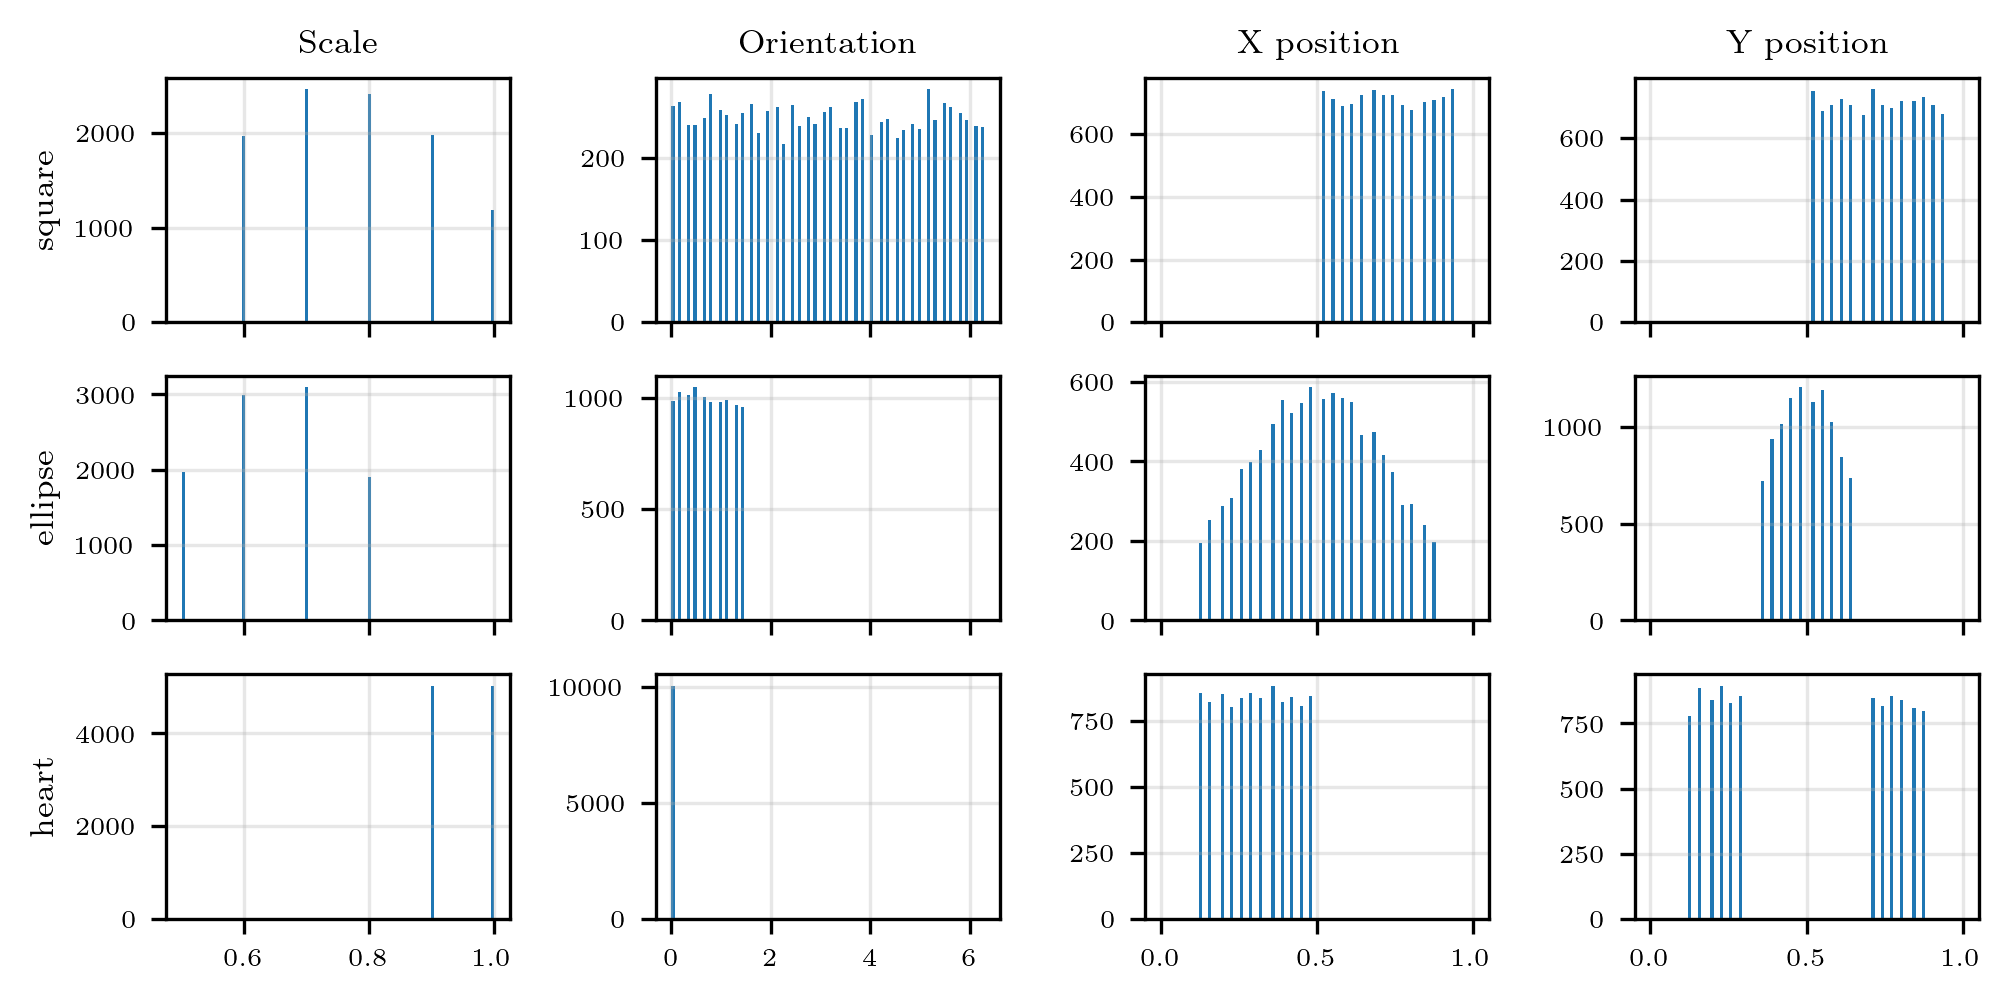

In [12]:

# Plot the distributions of the latents:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(text_width, text_width*0.5), sharex='col', dpi=300)

scale_bins = np.linspace(0.5, 1.0, 100)
orientation_bins = np.linspace(0.0, 2 * np.pi, 100)
x_position_bins = np.linspace(0.0, 1.0, 100)
y_position_bins = np.linspace(0.0, 1.0, 100)

# Squares:
axes[0, 0].hist([l.value_scale for l in latents_by_shape["square"]], bins=scale_bins)
axes[0, 1].hist([l.value_orientation for l in latents_by_shape["square"]], bins=orientation_bins)
axes[0, 2].hist([l.value_x_position for l in latents_by_shape["square"]], bins=x_position_bins)
axes[0, 3].hist([l.value_y_position for l in latents_by_shape["square"]], bins=y_position_bins)
axes[0, 0]. set_ylabel("square")

# Ellipses:
axes[1, 0].hist([l.value_scale for l in latents_by_shape["ellipse"]], bins=scale_bins)
axes[1, 1].hist([l.value_orientation for l in latents_by_shape["ellipse"]], bins=orientation_bins)
axes[1, 2].hist([l.value_x_position for l in latents_by_shape["ellipse"]], bins=x_position_bins)
axes[1, 3].hist([l.value_y_position for l in latents_by_shape["ellipse"]], bins=y_position_bins)
axes[1, 0]. set_ylabel("ellipse")

# Hearts:
axes[2, 0].hist([l.value_scale for l in latents_by_shape["heart"]], bins=scale_bins)
axes[2, 1].hist([l.value_orientation for l in latents_by_shape["heart"]], bins=orientation_bins)
axes[2, 2].hist([l.value_x_position for l in latents_by_shape["heart"]], bins=x_position_bins)
axes[2, 3].hist([l.value_y_position for l in latents_by_shape["heart"]], bins=y_position_bins)
axes[2, 0]. set_ylabel("heart")


# Share axes:
# for col in range(axes.shape[1]):
#     axes[0, col].get_shared_x_axes().join(
#         *(axes[row, col] for row in range(axes.shape[0]))
#     )



# Title everything:
axes[0, 0].set_title("Scale")
axes[0, 1].set_title("Orientation")
axes[0, 2].set_title("X position")
axes[0, 3].set_title("Y position")

plt.tight_layout()
plt.savefig("dsprites_latent_distributions.pdf", dpi=300, bbox_inches="tight", pad_inches=0.0)


Plot to make sure the latent histograms match the positions of samples visually

In [9]:
rows, cols = 8, 8  # How many examples to get for each shape
num_samples = rows * cols * 3 * 5
examples = list(ds.take(num_samples))

examples_by_shape = {
    "square": [e for e in examples if e["label_shape"] == 0],
    "ellipse": [e for e in examples if e["label_shape"] == 1],
    "heart": [e for e in examples if e["label_shape"] == 2],
}

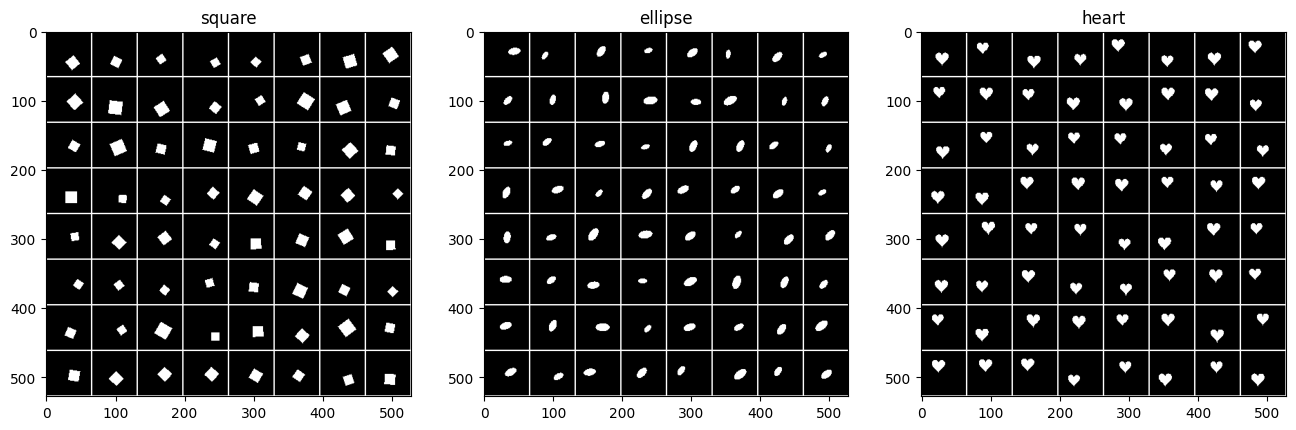

In [10]:
from typing import Sequence


def make_grid(
    images: Sequence,  # each of shape (H, W)
    nrows: int,
    ncols: int,
):
    assert len(images) == nrows * ncols
    # Concatenate the images:
    images = jnp.stack(images, axis=0)  # (nrows * ncols, H, W)
    # Reshape:
    images = jnp.reshape(images, (nrows, ncols, images.shape[1], images.shape[2]))
    # Now we need to swap axes to get the grid correctly
    images = jnp.transpose(images, (0, 2, 1, 3))
    # And finally reshape it to get the final grid
    return jnp.reshape(images, (nrows * images.shape[1], ncols * images.shape[3]))

def add_border(
    image: jnp.ndarray,  # (H, W)
    border_width: int = 1,
) -> jnp.ndarray:
    """Adds a border of zeros to the image"""
    assert image.ndim == 2
    assert border_width >= 1
    return jnp.pad(
        image,
        pad_width=border_width,
        mode="constant",
        constant_values=1,
    )


# Plot some examples:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

for col, shape in enumerate(["square", "ellipse", "heart"]):
    grid = make_grid(
        [add_border(e["image"].numpy().squeeze()) for e in examples_by_shape[shape][: rows * cols]],
        nrows=rows,
        ncols=cols,
    )
    axes[col].imshow(grid, cmap="gray")
    axes[col].set_title(shape)

Plot a couple samples with their latents on the side to confirm the tagged latents correspond to the image

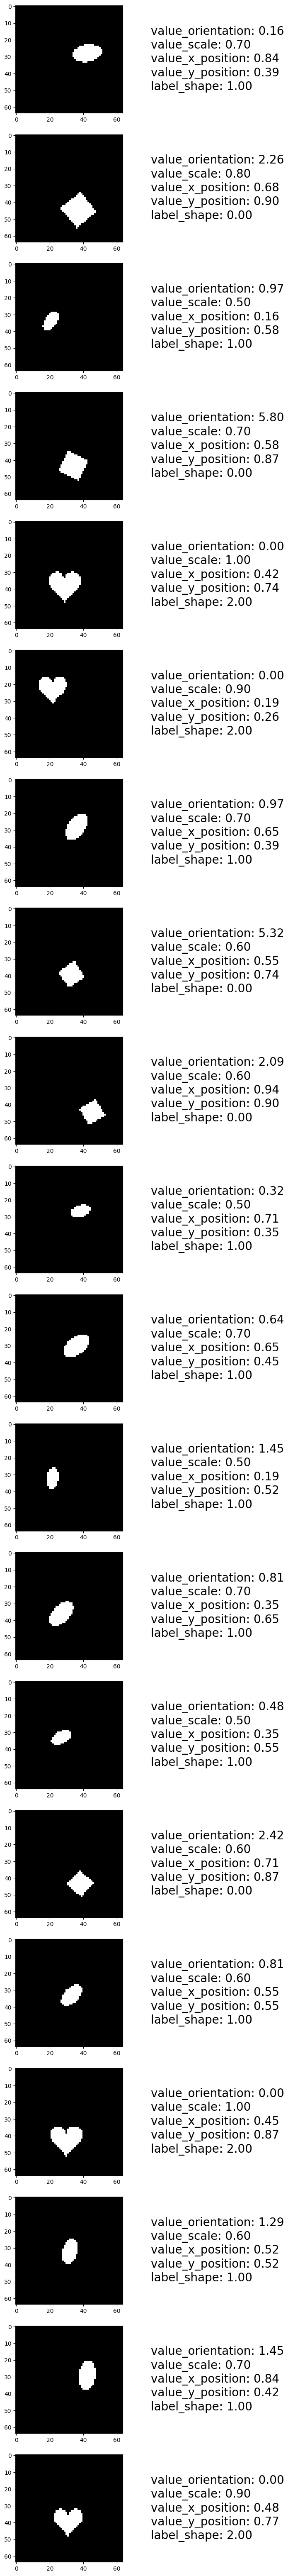

In [11]:
num_samples = 20
examples_and_latents = [(example["image"].numpy().squeeze(), extract_latents_from_example(example)) for example in ds.take(num_samples)]

fig, axes = plt.subplots(ncols=2, nrows=num_samples, figsize=(8, 4 * num_samples))
for i in range(num_samples):
    axes[i, 0].imshow(examples_and_latents[i][0], cmap="gray")
    # On the side, print the text of the latents:
    axes[i, 1].axis("off")
    axes[i, 1].text(
        0.0,
        0.5,
        "\n".join(f"{key}: {value:.2f}" for key, value in examples_and_latents[i][1]._asdict().items()),
        horizontalalignment="left",
        verticalalignment="center",
        fontsize=20,
    )
    

Check loading through the `get_data()` helper function works as exptected

In [12]:
from src.utils.input import get_data

config = ConfigDict()
config.dataset = "aug_dsprites"
config.batch_size = 512
config.shuffle_buffer_size = 2
config.pp_train = f'value_range(-1, 1, 0, 1)|keep(["image"])'
config.pp_eval = f'value_range(-1, 1, 0, 1)|keep(["image", "label_shape"])'

# These are no having any effect:
config.train_split = 0.8
config.val_split = 0.2

config.aug_dsprites = dsprites_config
train_ds, val_ds, _ = get_data(config, random.PRNGKey(1))

/homes/jua23/.virtualenvs/inv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [13]:
it = iter(train_ds)
%timeit next(it)

10.9 ms ± 3.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
